In [1]:
import scanpy as sc 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scvelo as scv
import bbknn
# sc.settings.set_figure_params(figsize=(5,4)) # 设置全局产生的图片尺寸
sc.settings.verbosity = 0 # 设置全局的waring数量，我这里直接不要求显示
sc.settings.set_figure_params(dpi_save=400, facecolor='white', fontsize=7, format='jpg')

In [2]:
adata = sc.read_h5ad("../data/aggr.h5ad")
scv.utils.clean_obs_names(adata)

In [3]:
adata.shape

(83174, 36601)

In [5]:
adata.X

<83174x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 246517793 stored elements in Compressed Sparse Row format>

### 展示每个样本有多少细胞

In [4]:
sample = np.unique(adata.obs['sample'])
for val in sample:
    print('Num of {} : {}'.format(val, adata[adata.obs['sample']==val].shape[0]))
print('total cells: ', adata.obs.shape[0])
adata.var_names_make_unique()

Num of AF-1 : 14044
Num of AF-2 : 12885
Num of AF-3 : 13055
Num of NAF-1 : 11279
Num of NAF-2 : 18073
Num of NAF-3 : 13838
total cells:  83174


## 以下不分这么细，全都一起做了

### 初步质控

In [5]:
sc.pp.filter_cells(adata, min_genes=200)# 每一个细胞至少表达n个基因
sc.pp.filter_genes(adata, min_cells=3)# 每一个基因至少在n个细胞中表达

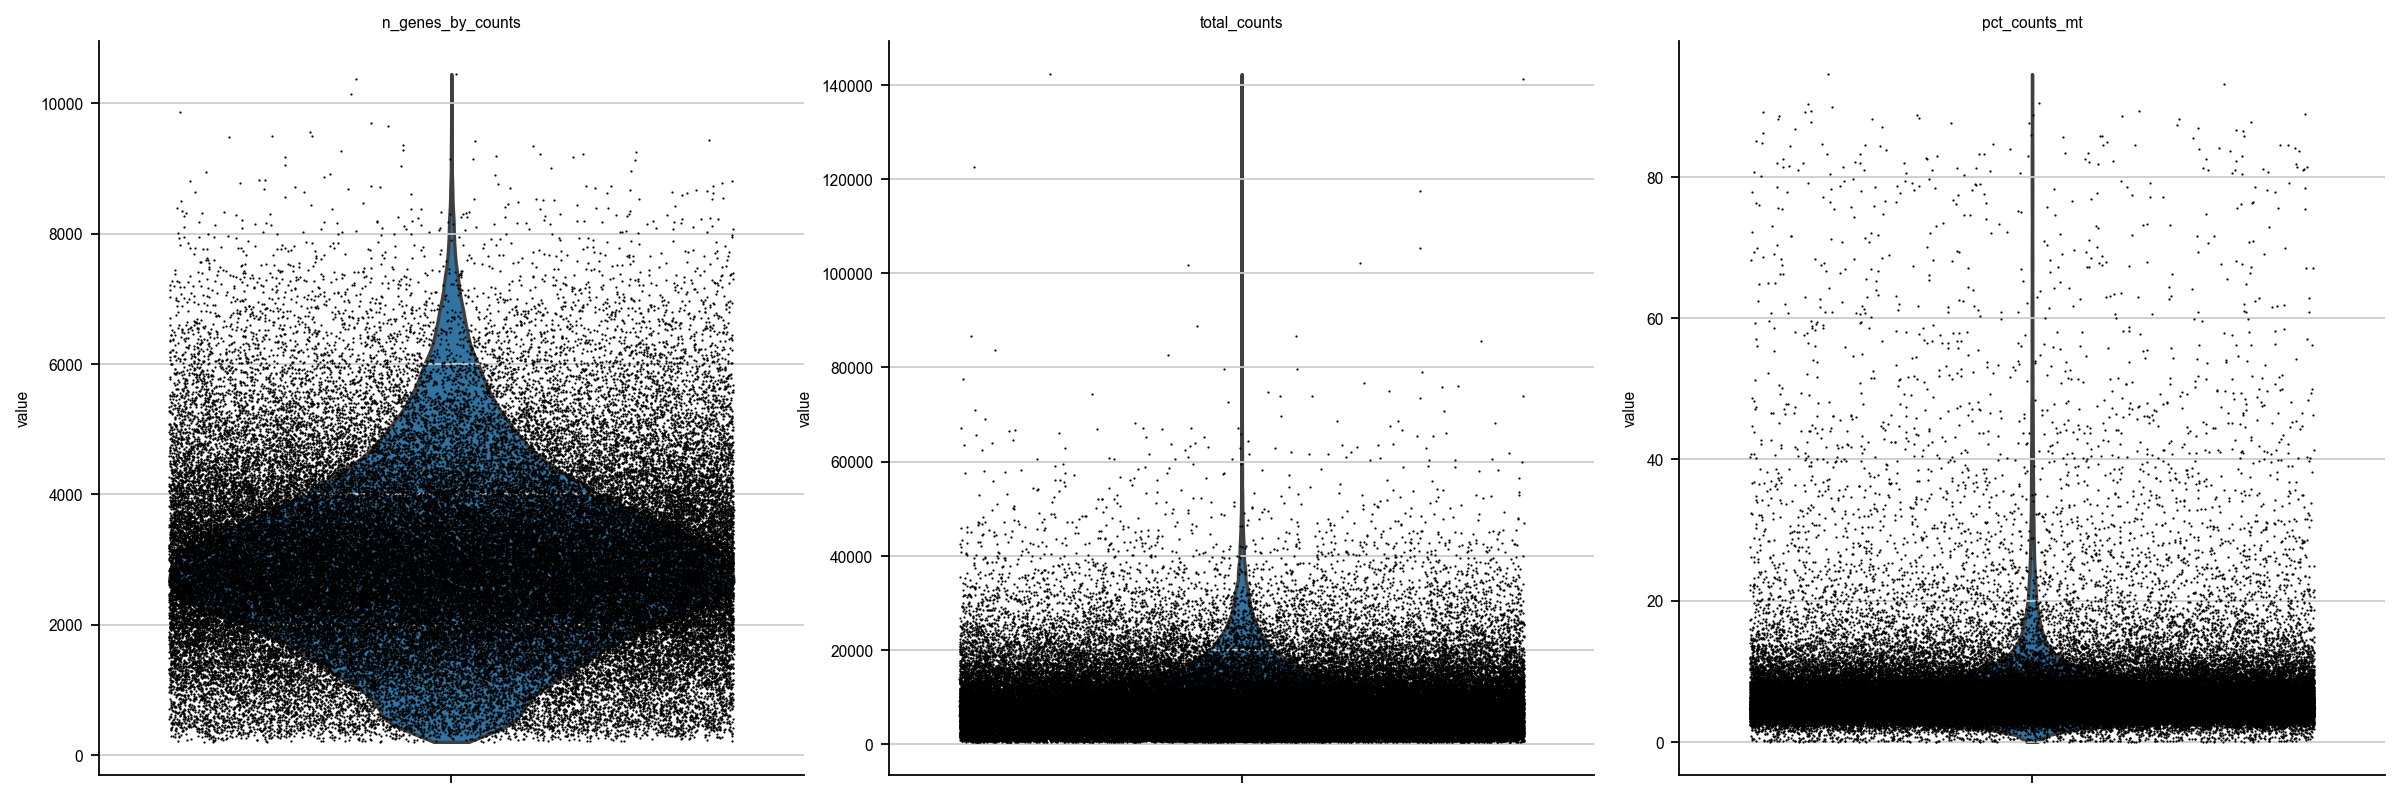

In [6]:
# 过滤线粒体，但注意最好搜一下，可能mt开头
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                     jitter=0.4, multi_panel=True, save=True)

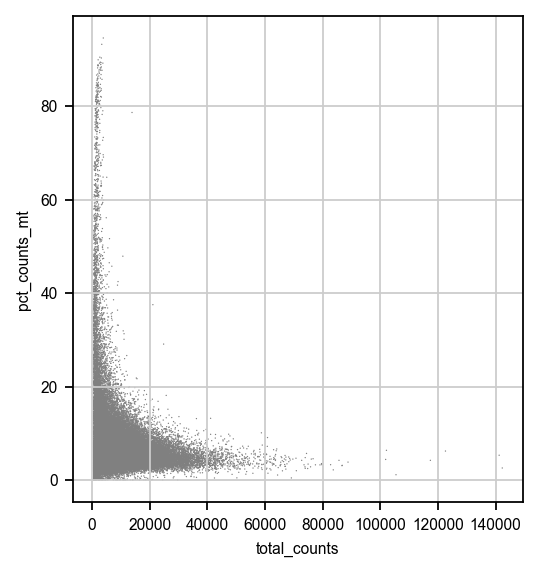

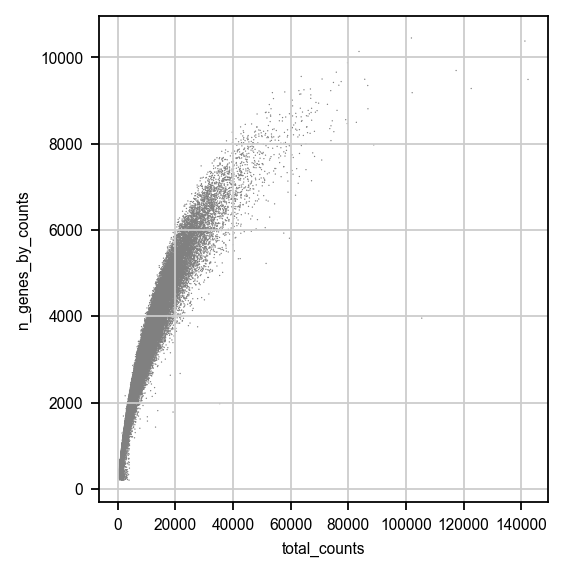

In [7]:
# 第一张图用于删选线粒体的比例，一般就是去掉上部的一些点
# 第二张图用于删选基因表达量，也是去掉上部一起很分散立群的点，可以稍微严格一点
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save='_pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='n_genes_by_counts')

In [8]:
ori = adata.obs.shape[0]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :] # 这里的数字就是你要卡的阈值，高于这个的都会被删掉
adata = adata[adata.obs.total_counts < 23000, :] 
# adata = adata[(adata.obs.total_counts/5 == adata.obs.n_genes_by_counts)&(adata.obs.total_counts>4000),:]
print('nums of filtered cells: ', ori - adata.obs.shape[0] )

nums of filtered cells:  14758


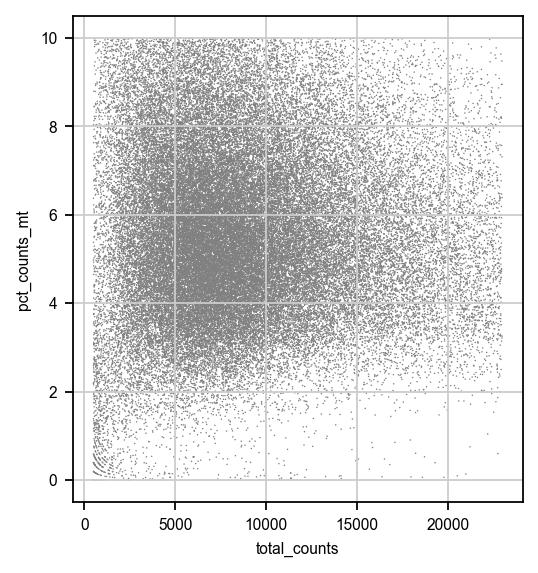

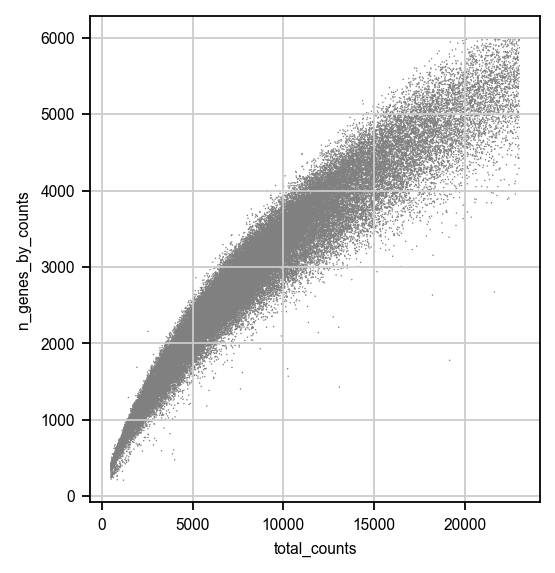

In [9]:
# 这里plot的图和上面一样，展示一下初步指控的结果
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save='_pct_counts_mt_after_QC')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='n_genes_by_counts_after_QC')

In [10]:
sample = np.unique(adata.obs['sample'])
for val in sample:
    print('Num of {} : {}'.format(val, adata[adata.obs['sample']==val].shape[0]))
    
print('total cells: ', adata.obs.shape[0])


Num of AF-1 : 11541
Num of AF-2 : 10639
Num of AF-3 : 9834
Num of NAF-1 : 9087
Num of NAF-2 : 15955
Num of NAF-3 : 11088
total cells:  68144


In [11]:
adata.write('../data/qc-v4.h5ad')

In [12]:
sc.pp.normalize_total?

In [13]:
# 对数据进行对数标准化（必须，基本不用改
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

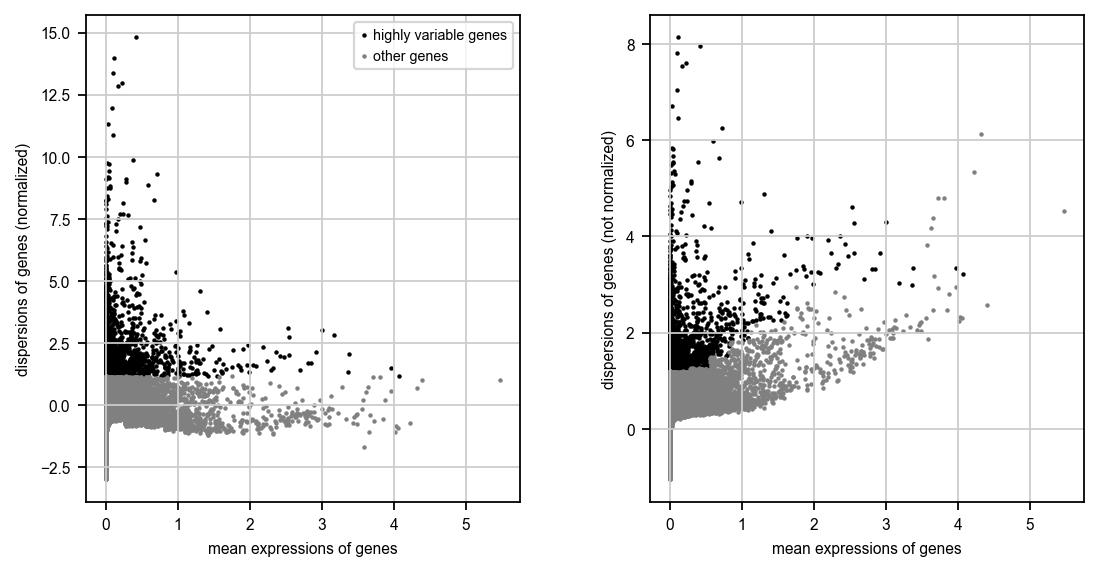

In [14]:
# 选择多少个高变基因进行后续的计算，看人，这个数值要根据结果调整
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata, save=True)
adata = adata[:, adata.var.highly_variable]

In [15]:
sc.pp.scale(adata, max_value=1, zero_center=False)

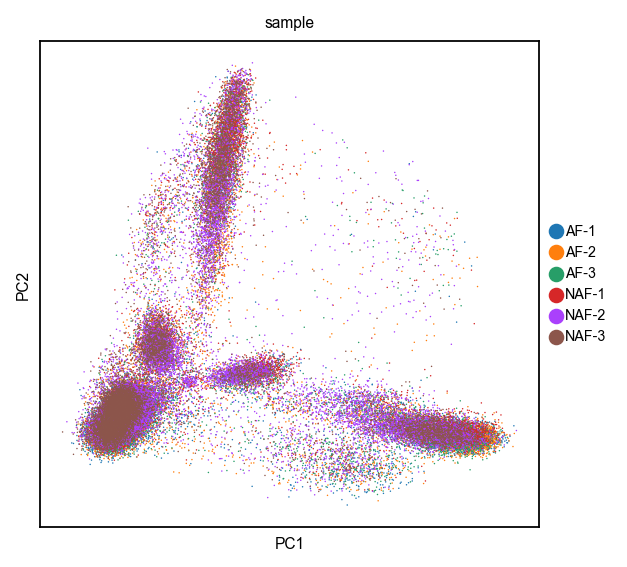

In [16]:
# 计算主成分
# 并按照样本进行plot
sc.tl.pca(adata, svd_solver='auto')
sc.pl.pca(adata, color='sample',save='_pca_sample')

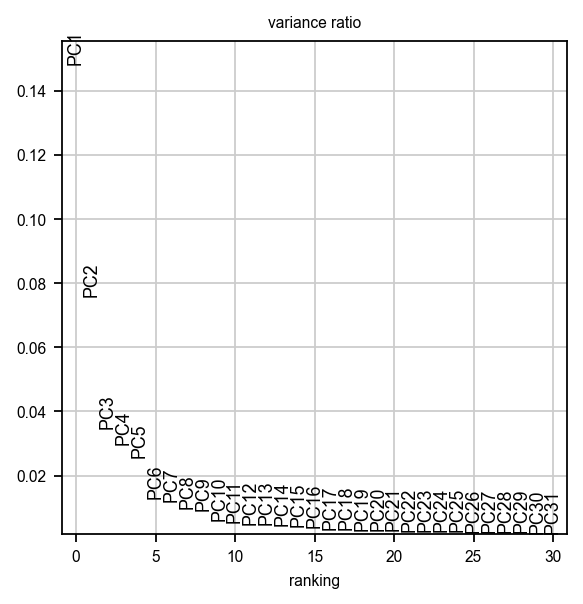

In [17]:
# 根据这个elbow图，选择后面用几个主成分进行计算
sc.pl.pca_variance_ratio(adata, log=False,save='_elbow') 

In [18]:
# 这个参数的n_pcs是根据前面的elbow图进行选择的
# 这一步是为了计算后面umap/tsne，否则无法计算umap和sne的嵌入
sc.pp.neighbors(adata, n_neighbors=150, n_pcs=6)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


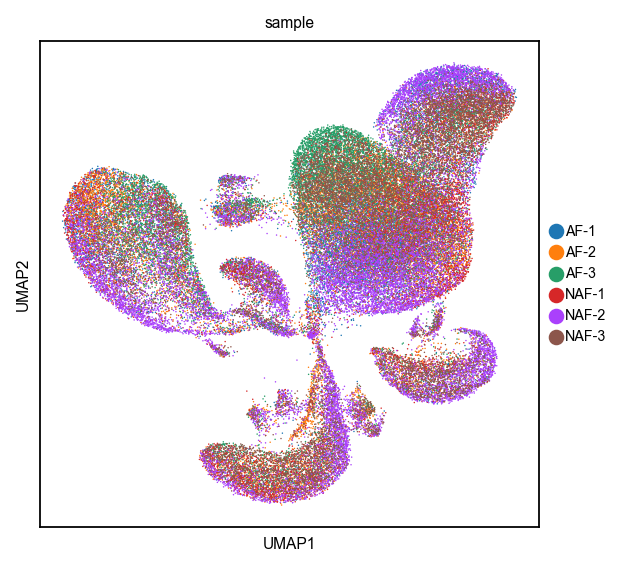

In [19]:
# 计算umap的嵌入值，这边可以把umap改成tsne
sc.tl.umap(adata, min_dist=0.7)
sc.pl.umap(adata, color=['sample'],save='_Sample_Non-batch-effect')

In [20]:
# 进行批次矫正
# 使用harmony：adjusted_basis是指会在原基础上进行修改，而不是多一列变量，key是要选择你记录样本的列
# sc.external.pp.harmony_integrate(adata, key='sample',
#                                  adjusted_basis='X_pca')
# sc.pp.neighbors(adata, n_neighbors=80, n_pcs=7)
# 使用bbknn：  n_pcs最好和前面一样，batch_key是样本列的名字
# adata = bbknn.bbknn(adata,n_pcs=6,trim=0, copy=True, batch_key='sample')

In [21]:
# # # 用于展示 批次矫正后的umap
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=['sample'],save='_Sample_batch-effect')

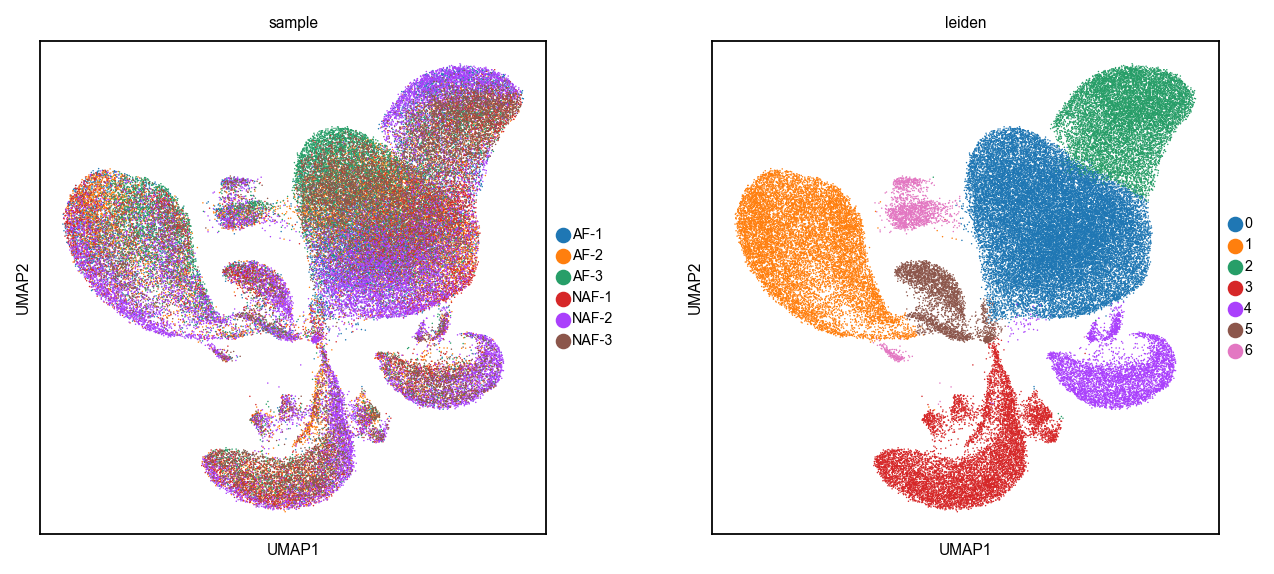

In [22]:
# 进行聚类计算，resolution控制聚类个数，越大聚类个数越多
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color=['sample','leiden'], save='_Leiden+Sample')

In [23]:
sum(pd.DataFrame(adata.X).isna())

0

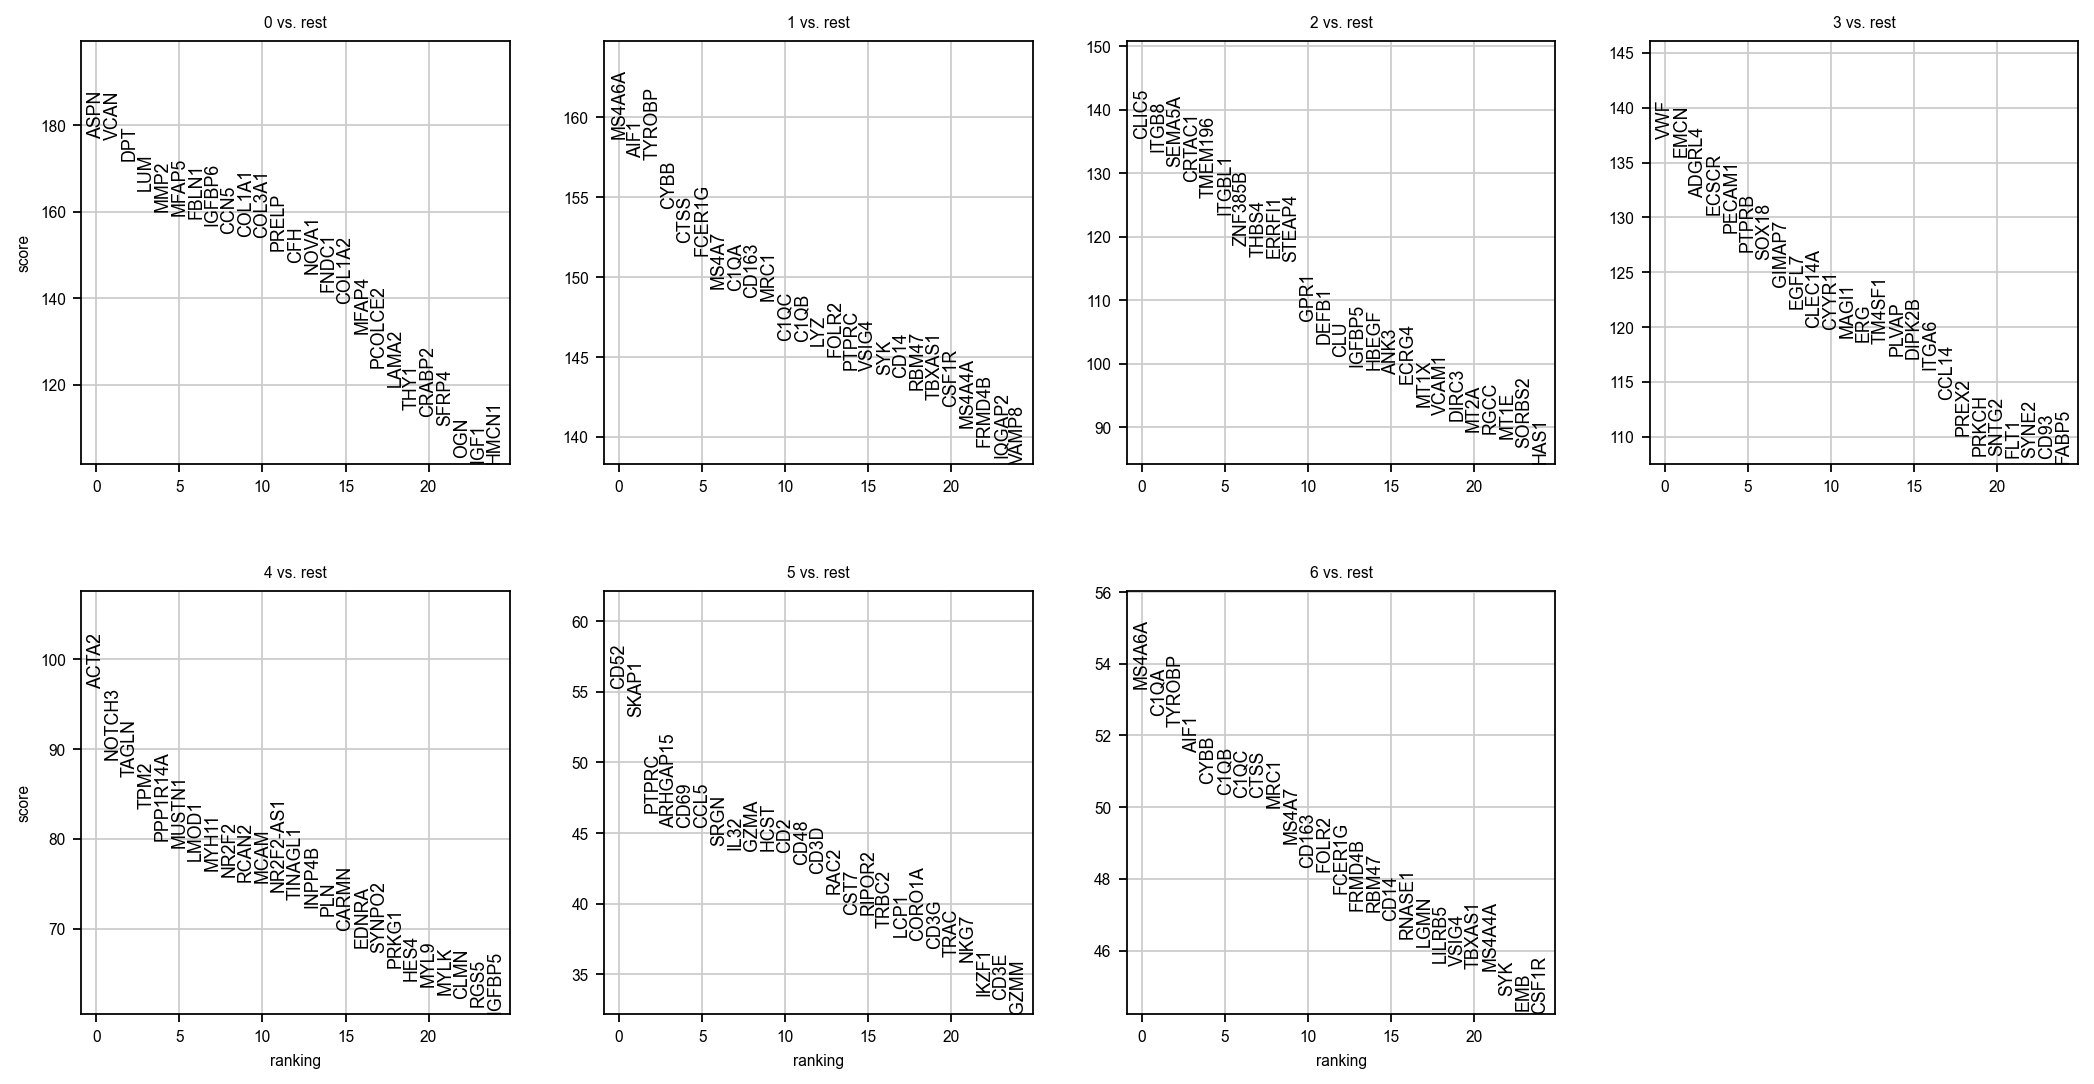

In [25]:
# 计算每个类别中的差异基因，是为了寻找每个类中的marker
# 但这一行代码也可以用于比较某两类的差异，groups=选择你`要区别的类，reference=如果不添加就是和其余剩下所有，加的话就是两类比较
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon',use_raw=False)
# 展示每个类和其他类的差异基因，展示前25个
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save=True)

In [26]:
# 讲计算得到的差异基因输出到excel，或者csv，推荐excel
result1 = adata.uns['rank_genes_groups']
groups = result1['names'].dtype.names
hvgdf = pd.DataFrame(
    {group + '_' + key: result1[key][group]
     for group in groups 
     for key in ['names', 'pvals','logfoldchanges']})
hvgdf.to_excel('./DEG/DEG-v4-total.xlsx')

In [27]:
adata.write('../data/v4.h5ad')

/Users/ckw/opt/anaconda3/envs/ckw/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(


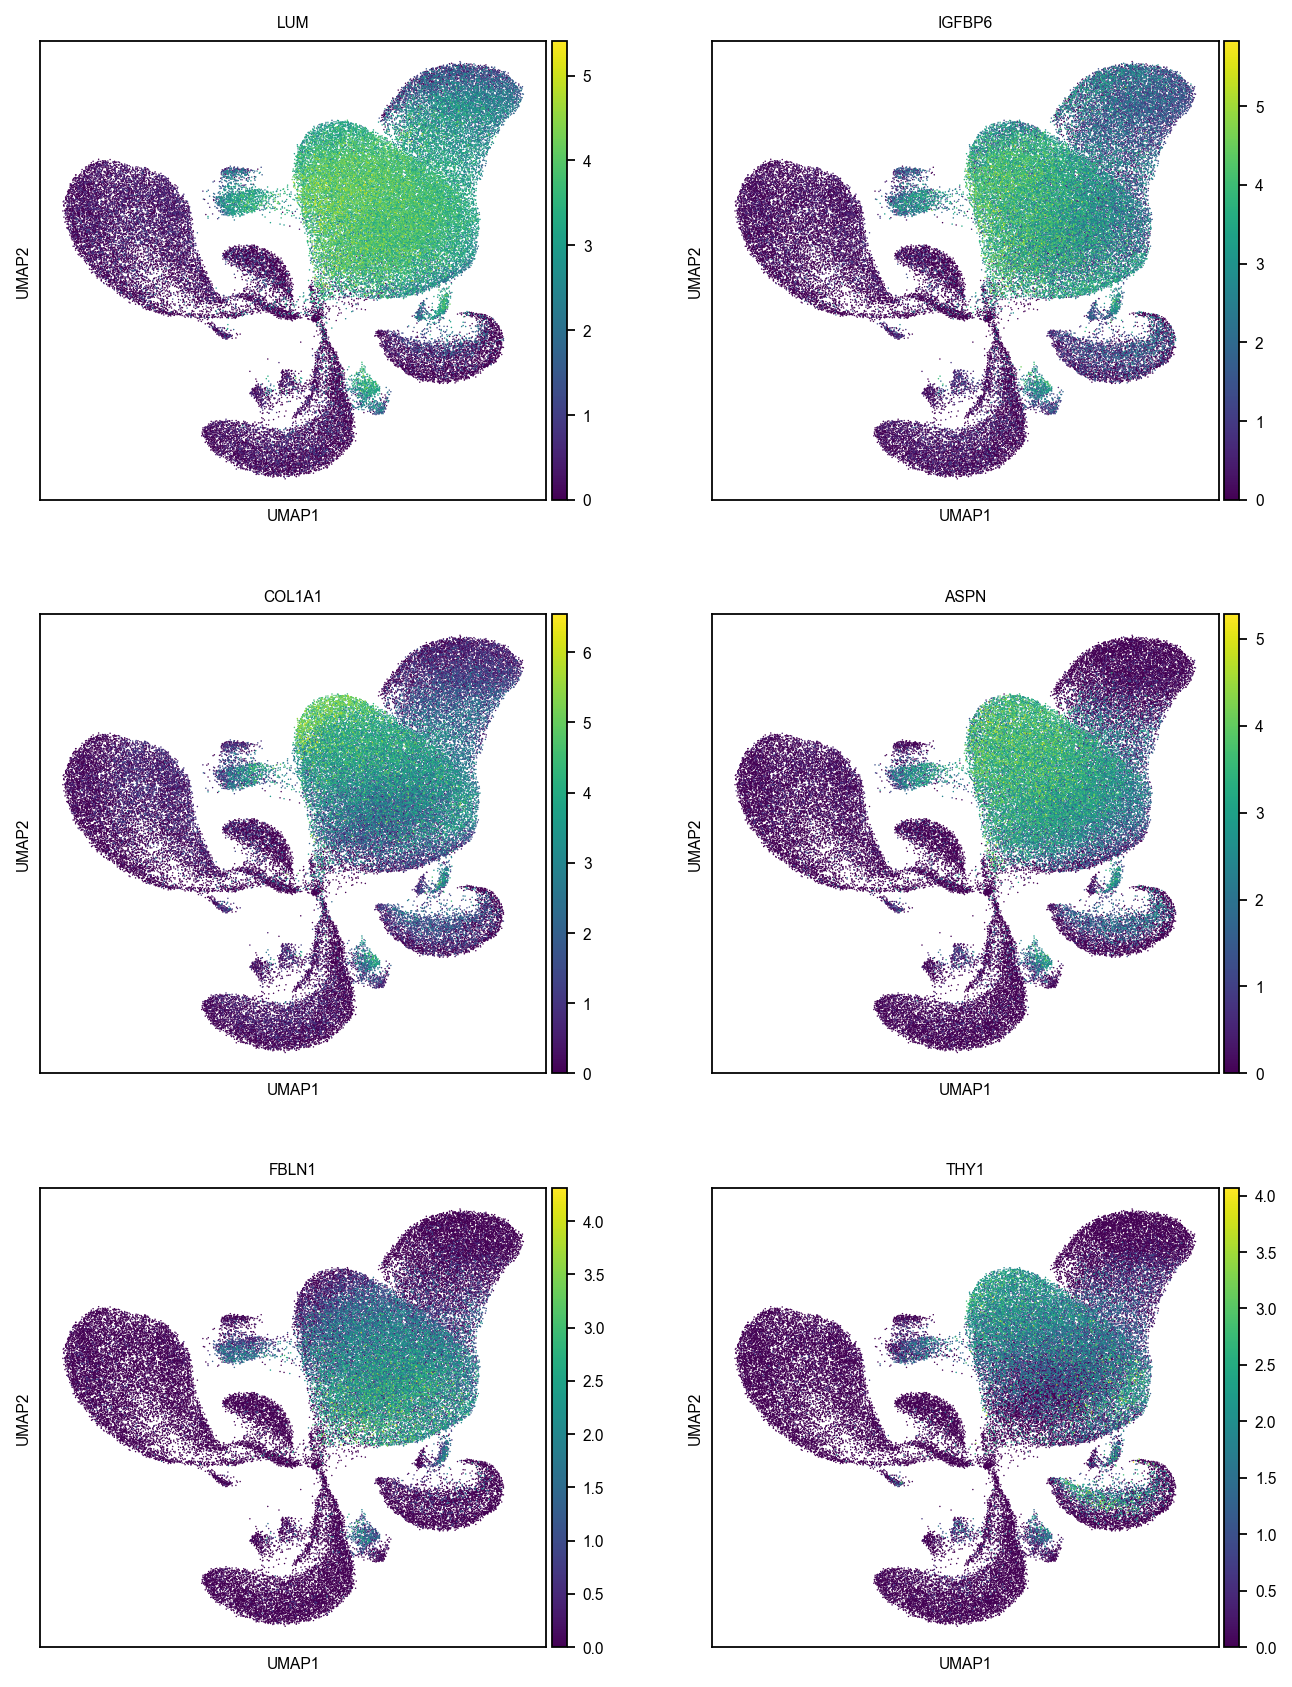

In [28]:
sc.pl.umap(adata, color=[ 'LUM','IGFBP6', 'COL1A1','ASPN', 'FBLN1', 'THY1'],ncols=2)

- 接下来，上面得到的xlsx你要下载到本地，然后一个个类去看里面的hvg，确定这个hvg是不是marker
- 首先你要看这gene是不是只在这个类里面高表达
-其次你要搜cellmarker/论文，这个gene是那些cell type的marker
- 最后你要多找几个进行验证

In [29]:
# adata = sc.read_h5ad('../data/10-6000-3w-pca:60+6-res:0.3+g22.h5ad')

### Fibroblasts:IGFBP6, ASPN, COL3A1

In [30]:
# 注释，注意必须按照leiden的类的数字顺序进行填写
# 注意，可能第一次是注释几个大类，那么后面需要加上下划线数字，因为索引要求唯一，不能相同，后面会通过代码进行矫正
new_cluster = [
    'Fibroblasts_0', # 0
    'Macrophages-M2_1', # 1 
    'Fibroblast-like Synoviocytes_2', # 2
    'Endothelial_3', # 3 
    'VSMC_4', # 4 
    'T cells_5',# 5  
    'Macrophages-M2_6', # 7
    

]

In [31]:
# 为leiden的类进行重命名
adata.rename_categories('leiden', new_cluster)

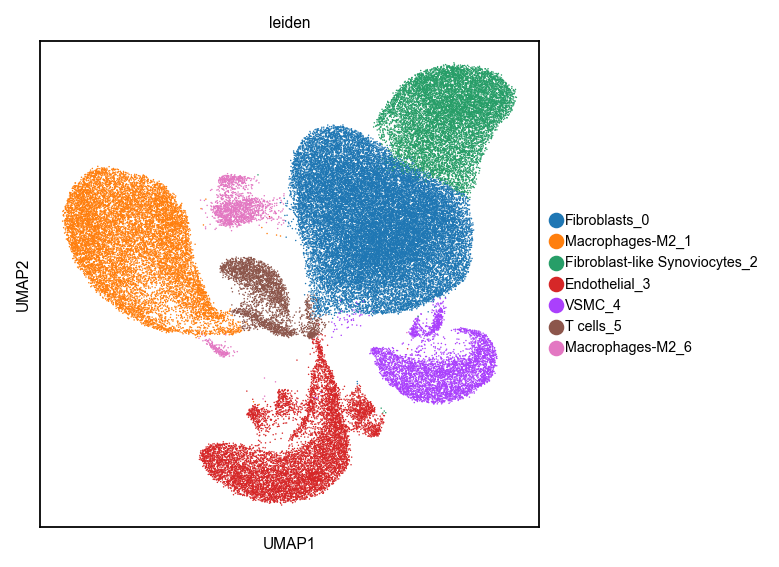

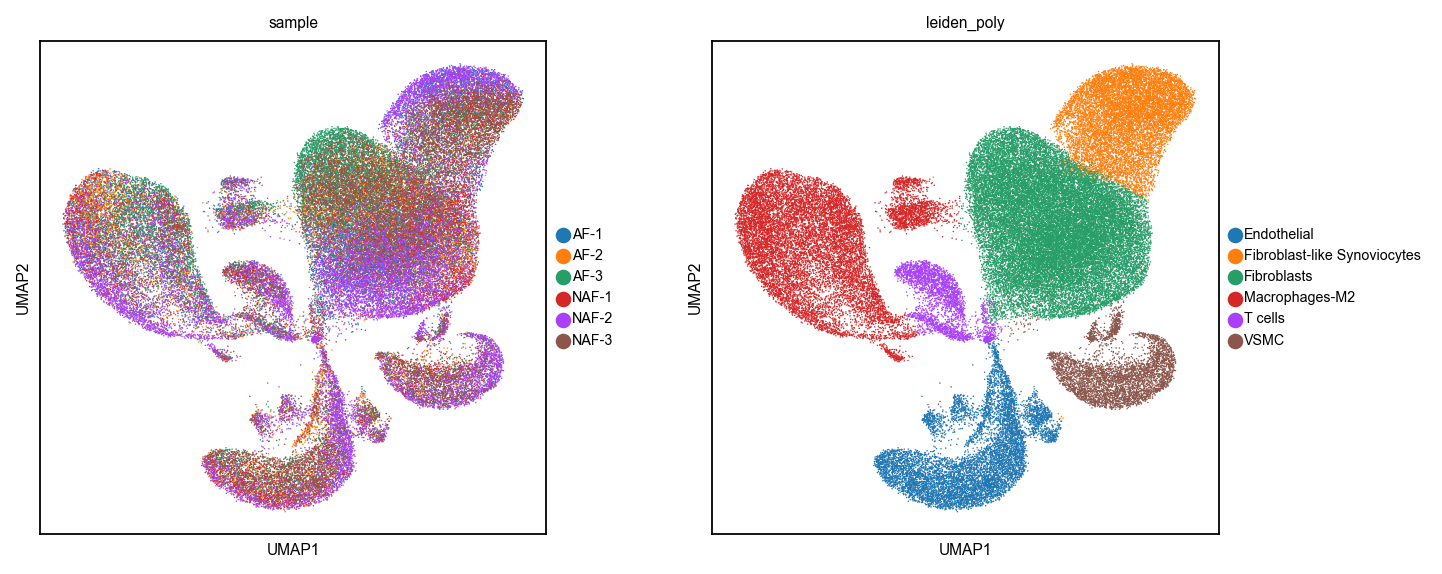

In [32]:
# 矫正到leiden_ poly
sc.pl.umap(adata, color='leiden')
adata.obs['leiden_poly'] = adata.obs['leiden'].str[:-2]
sc.pl.umap(adata, color=['sample','leiden_poly'])

In [33]:
# 储存结果,为后续细分亚群做准备，如果不保存，重新来一遍，结果可能会不一样
adata.write('../data/init_manual_anno-v4.h5ad')

In [34]:
fib_marker = [ 'LUM','IGFBP6', 'COL1A1','ASPN', 'FBLN1', 'THY1'] # Fibroblasts
macr_marker = ['MS4A6A', 'CD163', 'CD14', 'CYBB',] # Macrophages-m2
fib_syn_marker = [ 'CLIC5',  'HBEGF'] # Fibroblast-like Synoviocytes
end_marker = ['PTPRB', 'VWF', 'EMCN', 'ADGRL4'] # Endothelial Cells
VSMC_marker = ['NOTCH3', 'ACTA2', 'TAGLN', 'TPM2'] # Vascular Smooth Muscle Cells
TC_marker = ['CD2', 'CD3D'] # T Cells
marker_genes = fib_syn_marker + fib_marker + macr_marker + TC_marker+ end_marker + VSMC_marker 


# marker_genes = list(np.unique(marker_genes))

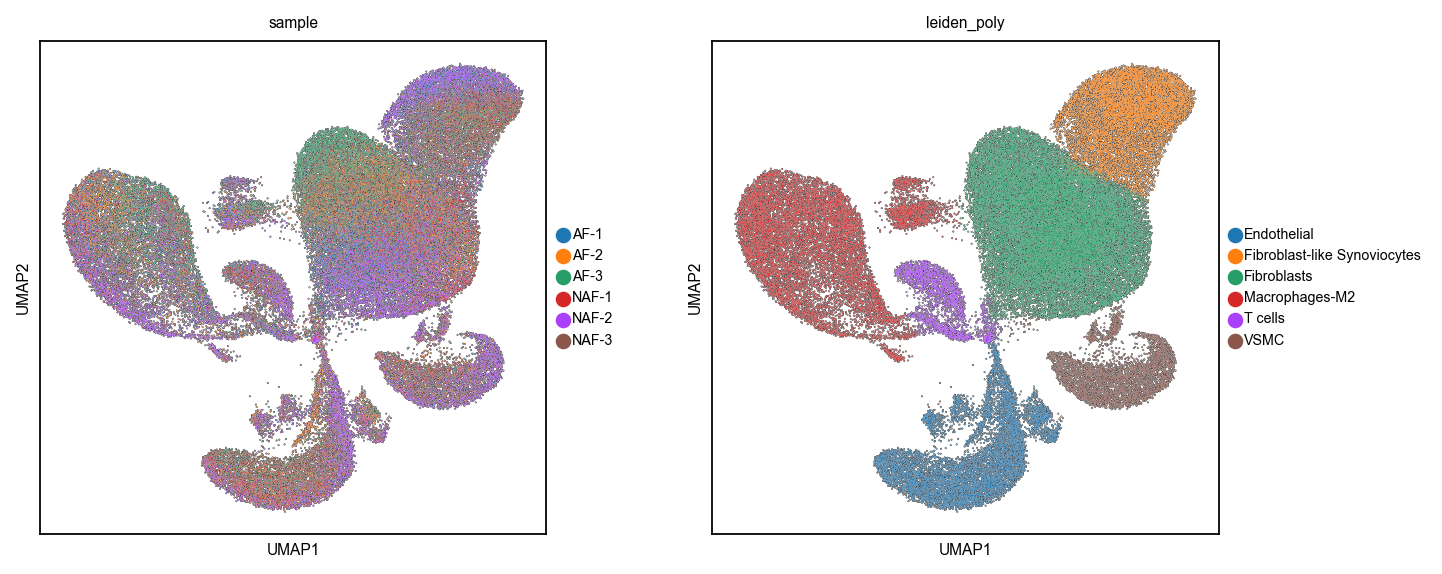

In [38]:
sc.pl.umap(adata, color=['sample','leiden_poly'], save='_Leiden+Sample',add_outline=True,size=1)